# XBeach Post Process

In [1]:
import sys;sys.path.append('../xbeach/')
from importlib import reload
from libs import *
from scipy.io import loadmat
import xbeach
from datetime import datetime,timedelta

In [2]:
root = pl.Path(r'Z:\Users\Tyler\projects\TNC\modeling\2d')
xb = nc4.Dataset(str(root / 'april28' / 'xboutput.nc'))
x,y = xbeach.utm2geo(xb.variables['globalx'][:,:],xb.variables['globaly'][:,:])
z = xb.variables['zb'][:,:,:]
t = xb.variables['meantime'][:]
zs = xb.variables['zs'][:,:,:]
h = xb.variables['H'][:,:,:]

In [20]:
root2 = pl.Path(r'Z:\Users\Tyler\projects\TNC\modeling\final_grid2')
vege_map = 'spartina_map.txt'

with open(str(root2/'flex_deal3.dep'),'r+') as fin:
    with open(str(root2/vege_map),'w+') as fout:
        lines = fin.readlines()
        for line in lines:
            data = line.strip().split('  ')
            for i in range(0,len(data)):
               # print(data)
                vege = []
                new = []
                if data != '':            
                    if float(data[i]) > 0.05:
                        fout.write('   '+str(1))
                    else:
                        fout.write('   '+str(0))
            fout.write('\n')

In [18]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(0,0.5,0.01)
time = np.arange(0,181,1)

In [15]:
data = zs
cmap = 'jet'
i = 5
data = h
label = 'elevation'

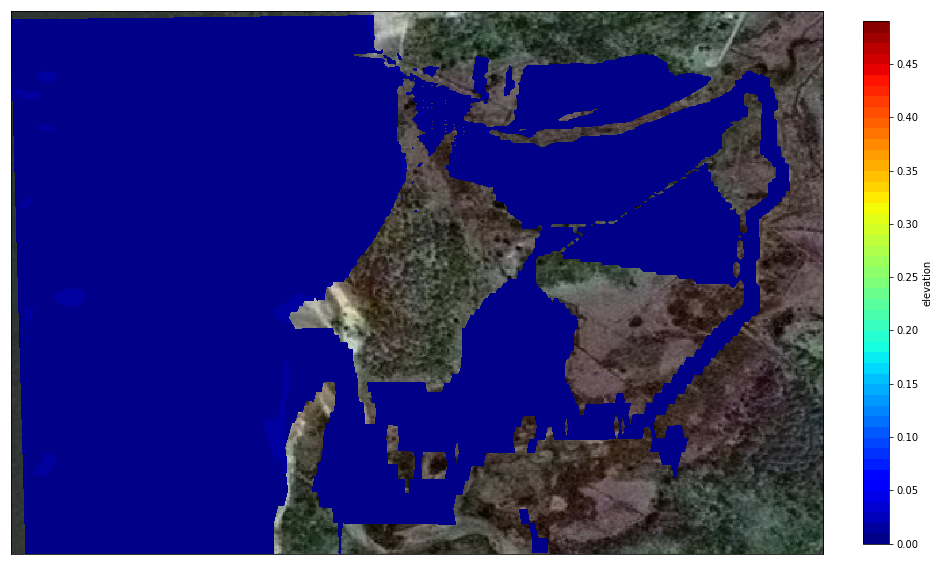

In [19]:
h[h.mask]=np.nan

fig,ax = plt.subplots(figsize=(18,10))
#data[data <=z] = np.nan
#wl.append('WL{}.png'.format(file_number))

plt.contourf(x,y,h[i,:,:],levels=levels,cmap=cmap,shading='gourand',vmin=np.min(levels),vmax=np.max(levels),aspect='auto')
m = Basemap(projection='cyl',llcrnrlat=lat1,urcrnrlat=lat2,llcrnrlon=lon1,
                    urcrnrlon=lon2,resolution='h', epsg = 4269)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 600, verbose= False)
cb = plt.colorbar(cmap=cmap,fraction=0.026,pad=0.04) 
cb.set_label(label,fontsize=10)
#ax.set_ylim(np.min(y)+0.0002,np.max(y)-0.0002)
#ax.set_xlim(np.min(x)+0.0002,np.max(x)-0.0002)
ax.autoscale_view(tight=True)

In [5]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.25,3.0001,0.05)
time = np.arange(0,181,1)
xbeach.map_plot(x,y,z,zs,time,title,levels,lat1,lat2,lon1,lon2)

<div align="middle"><img style="float:center;" src="xbeach.gif" width=700px></div>

In [8]:
def find_node_ak(x,y,obs_lat,obs_lon):
    min_distance = 30
    best_x = 0
    best_y = 0

    for i in range(0,144):
        for ii in range(0,353):
            current_distance = (y[i][ii] - obs_lat)**2 + (x[i][ii] - obs_lon)**2
            if min_distance is None or current_distance < min_distance:
                best_x = i
                best_y = ii
                min_distance = current_distance
    #print("best_index:{} ".format(best_index))
    return best_x,best_y

In [9]:
station_x = [-75.953653,-75.953486,-75.953338,-75.952953] # s1,s2,s3,s4
station_y = [38.151136,38.151207,38.151208,38.151215]
gridx,gridy = [], []
for i in range(0,4):
    node = find_node_ak(x,y,station_y[i],station_x[i])
    gridx.append(node[0])
    gridy.append(node[1])

In [10]:
def correct_hobo(mat_file):
    df1 = loadmat(mat_file)
    stat = ['S1','S2','S3','S4']
    data = []
    hobo = pd.DataFrame()
    for ii in range(0,len(stat)):
        dx,dt = [],[]
        wl = df1[stat[ii]]['height_NAVD88'][0][0].tolist()
        time = df1[stat[ii]]['time_NAVD88_cor'][0][0].tolist()
        for i2 in range(0,len(wl)):

            dx.append(float(wl[i2][0])-.75)

            dt.append(time[i2][0])
        for i in range(0,len(dx)-1):
            if dx[i+1]==dx[i] or dx[i]>1.75:
                dx[i]='NaN'
        water = pd.Series(dx)   
        timedepth = pd.to_datetime(pd.Series(dt)-719529, unit='D')
        #if ii == 0:
        hobo[stat[ii]+'_datetime'] = timedepth
        hobo[stat[ii]] = water

    return hobo

In [11]:
root2 = pl.Path(r'Z:\Project_TNC\3_Field\2_Data\2_Processed')
hobos = root2 / '1_hobo' / 'di_20180912_20181205'
water = correct_hobo(str(hobos / 't1.mat'))
time = pd.date_range(start=pd.to_datetime('2018-09-12 19'),periods=int(len(zs[:,gridx[0],gridy[0]])),freq='20min')
model = pd.DataFrame({'date time':time,'s1':zs[:,gridx[0],gridy[0]],'s2':zs[:,gridx[1],gridy[1]],
                      's3':zs[:,gridx[2],gridy[2]],'s4':zs[:,gridx[3],gridy[3]]})

In [8]:
data = zs

In [9]:
wl=[]
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.25,3.0001,0.05)
data[data.mask]=np.nan
start = '2018091216'
title = 'Deal Island '
start_date = datetime.strptime(start,'%Y%m%d%H')
for i in range(0,180):
    file_number = '%05d'%i
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.axes([0,0,0.6,1])
    ax2 = plt.axes([0.65,0.75,.55,.1])
    ax3 = plt.axes([0.65,0.55,.55,.1])
    ax4 = plt.axes([0.65,0.35,.55,.1])
    ax5 = plt.axes([0.65,0.15,.55,.1])
    wl.append('WL{}.png'.format(file_number))
    for ii in range(0,4):
        ax1.scatter(x[gridx[ii]][gridy[ii]],y[gridx[ii]][gridy[ii]],color='#ff00ff',s=200,zorder=4)
    ax1.contourf(x,y,data[i,:,:],levels=levels,cmap='jet',shading='gouraud',vmin=np.min(levels),vmax=np.max(levels),aspect='auto')
    m = Basemap(projection='cyl',llcrnrlat=lat1,urcrnrlat=lat2,llcrnrlon=lon1,
                        urcrnrlon=lon2,resolution='h', epsg = 4269,ax=ax1)
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 600, verbose= False)
    ax2.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    ax3.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    ax4.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    ax5.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    s1 = ax2.plot(pd.to_datetime(water['S1_datetime']),water['S1'],color='#0099cc')
    s2 = ax3.plot(pd.to_datetime(water['S2_datetime']),water['S2'],color='#0099cc')
    s3 = ax4.plot(pd.to_datetime(water['S3_datetime']),water['S3'],color='#0099cc')
    s4 = ax5.plot(pd.to_datetime(water['S4_datetime']),water['S4'],color='#0099cc')
    model1 = ax2.plot(model['date time'],model['s1'],'k')
    model2 = ax3.plot(model['date time'],model['s2'],'k')
    model3 = ax4.plot(model['date time'],model['s3'],'k')
    model4 = ax5.plot(model['date time'],model['s4'],'k')
    ax2.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    ax3.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    ax4.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    ax5.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    #cb = plt.colorbar(cmap='jet',fraction=0.026,pad=0.04) 
    #cb.set_label('elevation (m)',fontsize=10)
    ax2.set_ylim([-.2,1])
    ax3.set_ylim([-.2,1])
    ax4.set_ylim([-.2,1])
    ax5.set_ylim([-.2,1])

    ax2.set_title('station1')
    ax3.set_title('station2')
    ax4.set_title('station3')
    ax5.set_title('station4')
    ax5.legend(('Obs Station','model station'),
              loc='upper center',bbox_to_anchor=(0.5,-0.2),frameon=False,ncol=8)
    #ax2.set_xticks()
    ax1.set_title((title+str(start_date+ timedelta(minutes=i*20))))
    plt.savefig('WL{}.png'.format(file_number),dpi=400,bbox_inches = 'tight', pad_inches = 0.1)    
    plt.close()
images = []
for ii in range(0,len(wl)):
    frames = Image.open(wl[ii])
    images.append(frames)
images[0].save('xbeach2.gif',
   save_all=True,
   append_images=images[1:],
   delay=.1,
   duration=250,
   loop=0)
for f in glob.glob('WL*'):
    os.remove(f)  
    #plt.show()

<div align="middle"><img style="float:center;" src="xbeach2.gif" width=900px></div>

In [5]:
data =zs

In [24]:
import scipy

ValueError: different number of values and points

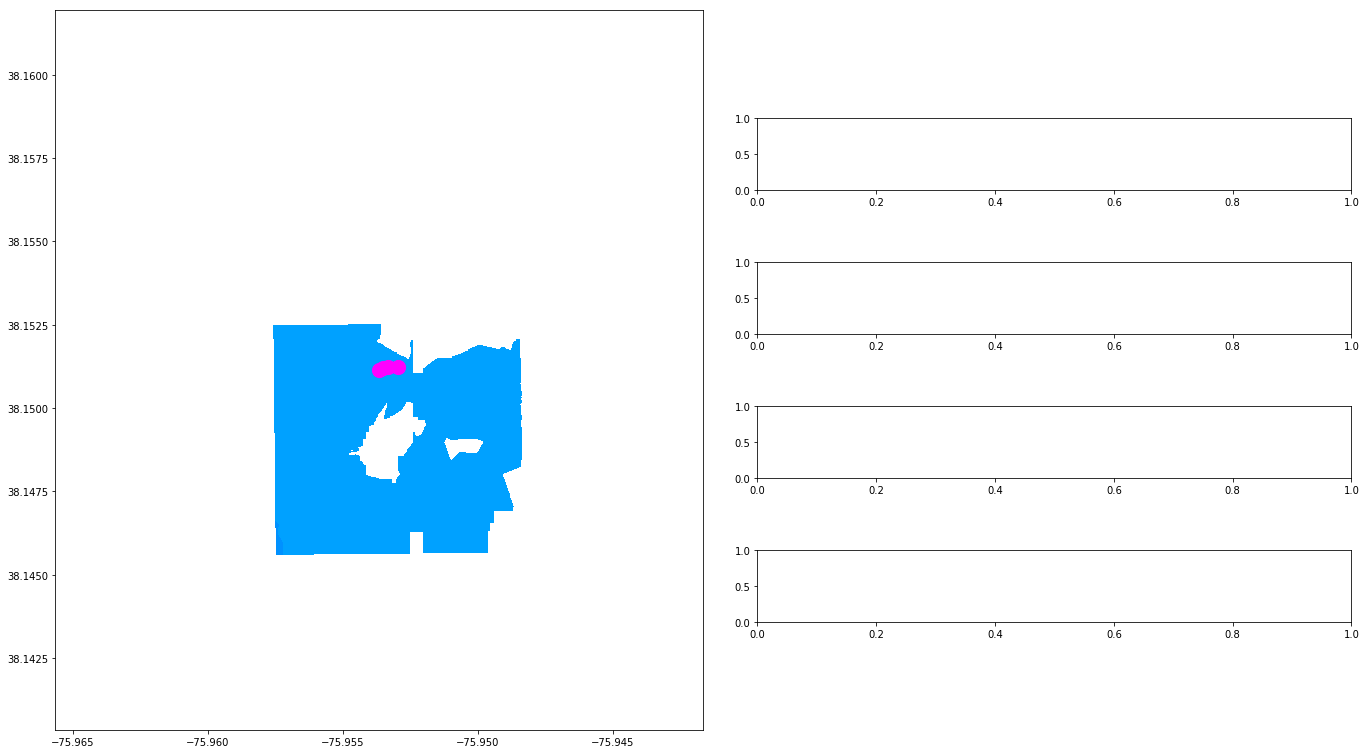

In [25]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.25,3.0001,0.05)
data[data.mask]=np.nan
start = '2018091216'
title = 'Deal Island '
u = xb.variables['u'][:,:,:]
v = xb.variables['v'][:,:,:]
u[u.mask]=np.nan
v[v.mask]=np.nan
wl = []
grid_space = 5
xg = np.linspace(lon1-0.001,lon2+0.001,grid_space)
yg = np.linspace(lat1-0.001,lat2+0.001,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
start_date = datetime.strptime(start,'%Y%m%d%H')
for i in range(100,101):
    file_number = '%05d'%i
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.axes([0,0,0.6,1])
    ax2 = plt.axes([0.65,0.75,.55,.1])
    ax3 = plt.axes([0.65,0.55,.55,.1])
    ax4 = plt.axes([0.65,0.35,.55,.1])
    ax5 = plt.axes([0.65,0.15,.55,.1])
    wl.append('WL{}.png'.format(file_number))
    for ii in range(0,4):
        ax1.scatter(x[gridx[ii]][gridy[ii]],y[gridx[ii]][gridy[ii]],color='#ff00ff',s=200,zorder=4)
    ax1.contourf(x,y,data[i,:,:],levels=levels,cmap='jet',shading='gouraud',vmin=np.min(levels),vmax=np.max(levels),aspect='auto')
    m = Basemap(projection='cyl',llcrnrlat=lat1,urcrnrlat=lat2,llcrnrlon=lon1,
                        urcrnrlon=lon2,resolution='h', epsg = 4269,ax=ax1)
    ugrid = scipy.interpolate.griddata((x,y),u[i:,:],(xgrid,ygrid),method='nearest')
    vgrid = scipy.interpolate.griddata((x,y),v[i,:,:],(xgrid,ygrid),method='nearest')
    ax1.quiver(xgrid,ygrid,ugrid,vgrid,zorder=3)
    m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 600, verbose= False)
    ax2.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    ax3.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    ax4.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    ax5.plot((model['date time'][i],model['date time'][i]),(-5,5),'k')
    s1 = ax2.plot(pd.to_datetime(water['S1_datetime']),water['S1'],color='#0099cc')
    s2 = ax3.plot(pd.to_datetime(water['S2_datetime']),water['S2'],color='#0099cc')
    s3 = ax4.plot(pd.to_datetime(water['S3_datetime']),water['S3'],color='#0099cc')
    s4 = ax5.plot(pd.to_datetime(water['S4_datetime']),water['S4'],color='#0099cc')
    model1 = ax2.plot(model['date time'],model['s1'],'k')
    model2 = ax3.plot(model['date time'],model['s2'],'k')
    model3 = ax4.plot(model['date time'],model['s3'],'k')
    model4 = ax5.plot(model['date time'],model['s4'],'k')
    ax2.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    ax3.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    ax4.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    ax5.set_xlim([pd.to_datetime('2018-09-12 19'),model.iloc[-1]['date time']])
    #cb = plt.colorbar(cmap='jet',fraction=0.026,pad=0.04) 
    #cb.set_label('elevation (m)',fontsize=10)
    ax2.set_ylim([-.2,1])
    ax3.set_ylim([-.2,1])
    ax4.set_ylim([-.2,1])
    ax5.set_ylim([-.2,1])

    ax2.set_title('station1')
    ax3.set_title('station2')
    ax4.set_title('station3')
    ax5.set_title('station4')
    ax5.legend(('Obs Station','model station'),
              loc='upper center',bbox_to_anchor=(0.5,-0.2),frameon=False,ncol=8)
    #ax2.set_xticks()
    ax1.set_title((title+str(start_date+ timedelta(minutes=i*20))))
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime,timedelta

h[h.mask]=np.nan
zs[zs<=z]=np.nan
wl=[]
start = '2018091216'
title = 'Deal Island '
start_date = datetime.strptime(start,'%Y%m%d%H')
for i in range(0,181):
    file_number = '%05d'%i
    fig = plt.figure(figsize=(18,10))
    ax = fig.add_subplot(111, projection='3d')
    original = ax.plot_surface(x,y,z[i,:,:],cmap='gist_earth',vmin=-1.,vmax=2,antialiased=False, shade=False)
    #water = ax.plot_surface(x,y,zs[i,:,:],color='#3333ff',antialiased=False, shade=False)
    waves = ax.plot_surface(x,y,h[i,:,:]+zs[i,:,:],cmap='cool', rstride=1, cstride=1,vmin=-.2,vmax=2,antialiased=False, shade=True)
    wl.append('WL{}.png'.format(file_number))
    ax.set_zlim(-1, 3)
    ax.view_init(30,azim=235)
    ax.autoscale_view(tight=True)
    ax.set_title(title+str(start_date+ timedelta(minutes=i*20)))
    ax.set_ylim(np.min(y)+0.002,np.max(y)-0.002)
    ax.set_xlim(np.min(x)+0.002,np.max(x)-0.002)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig('WL{}.png'.format(file_number),dpi=300,bbox_inches = 'tight', pad_inches = 0.1)
    plt.close()
images = []
for ii in range(0,len(wl)):
    frames = Image.open(wl[ii])
    images.append(frames)
images[0].save('xbeach3d.gif',
   save_all=True,
   append_images=images[1:],
   delay=.1,
   duration=200,
   loop=0)
for f in glob.glob('WL*'):
    os.remove(f)  
#cb = plt.colorbar(cmap='jet',fraction=0.026,pad=0.04)
#cb.set_label('Elevation (m) at NAVD88',fontsize=10)

<div align="middle"><img style="float:center;" src="xbeach3d.gif" width=700px></div>

In [51]:
from mpl_toolkits.mplot3d import Axes3D
from PIL import *
import glob
from datetime import datetime, timedelta
start = '20180912'
title = 'Deal Island'
start_date = datetime.strptime(start,'%Y%m%d%H')
wl=[]

for i in range(0,122):
    file_number = '%05d'%i
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    water = ax.plot_surface(x,y,xb.variables['zs_mean'][i,:,:]-0.001,color='#3333ff',alpha=.75)
    #waves = ax.plot_surface(x,y,xb.variables['zs_mean'][i,:,:]+xb.variables['H_mean'][i,:,:],color='#00b8e6',alpha=.75)
    #original = ax.plot_surface(x,y,xb.variables['zb_mean'][i,:,:]+0.001,cmap='gist_earth',vmin=-1.,vmax=2)
    
    wl.append('WL{}.png'.format(file_number))
    ax.set_title(title)
    #ax.set_zlim(-1, 3)
    #ax.set_xlim(416200,416600)
    #ax.set_ylim(4222700,4223040)
    #ax.view_init(15,azim=105)
    #ax.autoscale_view(tight=True)
    #cb = plt.colorbar(cmap='jet',fraction=0.026,pad=0.04)
    #cb.set_label('Elevation (m) at NAVD88',fontsize=10)
    plt.savefig('WL{}.png'.format(file_number),dpi=300,bbox_inches = 'tight', pad_inches = 0.1)
    plt.close()
images = []
for ii in range(0,len(wl)):
    frames = Image.open(wl[ii])
    images.append(frames)
images[0].save('xbeach.gif',
   save_all=True,
   append_images=images[1:],
   delay=.1,
   duration=200,
   loop=0)
for f in glob.glob('WL*'):
    os.remove(f)    